In [116]:
# ------------------------------------------------------------------------------
# STANDARD LIBRARY IMPORTS
# ------------------------------------------------------------------------------
import os
import re
import glob
import pickle
import time
import random
from datetime import datetime

# ------------------------------------------------------------------------------
# NUMERICAL COMPUTATION AND DATA MANIPULATION
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree, Voronoi, voronoi_plot_2d
from scipy.stats import linregress, gaussian_kde
from sklearn.metrics import f1_score, r2_score, pairwise_distances
from sklearn.linear_model import LinearRegression
import sklearn

# ------------------------------------------------------------------------------
# GEOMETRY AND GIS PROCESSING
# ------------------------------------------------------------------------------
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Geod
import geopandas as gpd
import rasterio
import matplotlib.patches as mpatches

# ------------------------------------------------------------------------------
# CAMERA TRANSFORMATION
# ------------------------------------------------------------------------------
import cameratransform as ct

# ------------------------------------------------------------------------------
# IMAGE PROCESSING
# ------------------------------------------------------------------------------
import cv2
from PIL import Image

# ------------------------------------------------------------------------------
# DATA VISUALIZATION
# ------------------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mpl_dates
from matplotlib.transforms import ScaledTranslation
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import gridspec

# ------------------------------------------------------------------------------
# CLICKPOINTS (FOR INTERACTIVE ANNOTATION)
# ------------------------------------------------------------------------------
import clickpoints

# ------------------------------------------------------------------------------
# PROGRESS TRACKING
# ------------------------------------------------------------------------------
from tqdm import tqdm
tqdm.pandas()  # Enable tqdm for pandas

# ------------------------------------------------------------------------------
# JUPYTER NOTEBOOK SETTINGS (FOR INLINE PLOTTING)
# ------------------------------------------------------------------------------
%matplotlib inline

# ------------------------------------------------------------------------------
# MATPLOTLIB CONFIGURATION
# ------------------------------------------------------------------------------
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 9


In [2]:
colors = {
    'female': '#1F77B4',
    'male': '#FF7F0E',
    'pup': '#2CA02C',
    'giant petrel': '#9467bd', #purple
    'skua': '#8C564B', #brown
    'sheathbill': '#e377c2', #pink
    'bird': '#E377C2',
    'snowy sheathbill': '#e377c2',  # Same as 'sheathbill'
    'brown skua': '#8C564B'        # Same as 'skua'
}

def create_colormap(base_color):
    """
    Create a custom colormap that transitions from white to the given base color.

    Parameters:
        base_color (str or RGB tuple): The base color for the colormap.

    Returns:
        LinearSegmentedColormap: A custom colormap object.
    """
    return LinearSegmentedColormap.from_list("custom_colormap", ["white", base_color])


cmaps = {name: create_colormap(color) for name, color in colors.items()}

In [3]:
labels = {
    'male' : 'adult male',
    'female' : 'adult female',
    'pup' : 'pup',
    'giant petrel' : 'giant petrel',
    'sheathbill' : 'snowy sheathbill',
    'skua' : 'brown skua',
}

In [7]:
# ------------------------------------------------------------------------------------------
# HELPER FUNCTIONS
# ------------------------------------------------------------------------------------------

In [84]:
def load_df_from_pickle(filepath,folder="files"):
    filepath = os.path.join(folder,filepath)
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    # Load the DataFrame from the pickle file
    with open(filepath, "rb") as f:
        df = pickle.load(f)

    return df

def save_df_to_pickle(df, filename, folder="files"):

    # Ensure the folder exists
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Create the full file path
    filepath = os.path.join(folder, filename)

    # Save the DataFrame to a pickle file
    with open(filepath, "wb") as f:
        pickle.dump(df, f)

    return filepath


# Load (raw) datasets

In [86]:
# define fiolder
folder = "files"

In [9]:
manual = load_df_from_pickle('manual.pkl')
fwb = load_df_from_pickle('fwb.pkl')

In [10]:
length_fwb = len(fwb)
length_manual = len(manual)

In [11]:
fwb.columns

Index(['image_id', 'filename', 'timestamp', 'position_x_px', 'position_y_px',
       'width_px', 'height_px', 'class', 'latitude', 'longitude',
       'position_x_meter', 'position_y_meter', 'laplace'],
      dtype='object')

In [12]:
fwb.groupby(["class"])["class"].count()

class
bird               30320
elephant seal       1209
female           1392888
fur seal           24608
giant petrel      112594
male             1624932
penguin            49459
pup              1367796
sheathbill        233304
skua              284932
Name: class, dtype: int64

In [13]:
manual.groupby(["class"])["class"].count()

class
bird                 102
blond pup              9
dead pup              89
elephant seal         24
female              6874
field researcher       2
fur seal              77
giant petrel         317
kelp gull              4
male                6083
penguin              205
pup                 6749
scavenging            22
seal                  65
sheathbill           792
skua                1187
Name: class, dtype: int64

# Filter datasets

## Filter: Time of Day (09:00–17:00)

In [14]:
# Retain only images captured between 09:00 and 17:00 local time to reduce the impact of low-light conditions
# on detection quality. This minimizes visibility issues caused by morning/evening shadows or darkness.

In [15]:
fwb = fwb[(fwb['timestamp'].dt.hour >= 9) & (fwb['timestamp'].dt.hour < 17)]
print(f"Remaining entries: {len(fwb)}/{length_fwb} ({len(fwb)/length_fwb:.1%})")

Remaining entries: 5122042/5122042 (100.0%)


## Filter: image quality based on LaPlace [cv2.Laplacian]

In [16]:
# Use Laplacian variance to quantify image sharpness and exclude blurry images caused by fog, lens droplets,
# or motion blur. Threshold optimized for best F1 score using manually labeled training set and determined to 30

In [25]:
threshold = 30

In [26]:
manual = manual[manual.laplace >= threshold]
print(f"Remaining entries in manual: {len(manual)}/{length_manual} ({len(manual)/length_manual:.1%})")


Remaining entries in manual: 19121/22601 (84.6%)


In [27]:
length = len(fwb)
fwb = fwb[fwb.laplace >= threshold]
print(f"Remaining entries in manual: {len(fwb)}/{length_fwb} ({len(fwb)/length_fwb:.1%})")

Remaining entries in manual: 4140866/5122042 (80.8%)


## Filter: Key species

In [20]:
# Focus analysis on the most ecologically relevant species: adult male, adult female, pup, brown skua, snowy sheathbill,
# and giant petrel. Rare species such as leopard seals, elephant seals, kelp gulls, and king penguins are excluded.

In [28]:
keyspecies = ["male", "female", "pup", "giant petrel", "skua", "sheathbill"]

In [29]:
manual = manual[manual["class"].isin(keyspecies)]
print(f"Remaining entries in manual: {len(manual)}/{length_manual} ({len(manual)/length_manual:.1%})")

Remaining entries in manual: 19121/22601 (84.6%)


In [30]:

fwb = fwb[fwb["class"].isin(keyspecies)]
print(f"Remaining entries in fwb: {len(fwb)}/{length_fwb} ({len(fwb)/length_fwb:.1%})")

Remaining entries in fwb: 4140866/5122042 (80.8%)


## Filter: Pups before first born pup

In [31]:
# Exclude automated annotations of pups made before the first confirmed pup birth (18th November), as these are
# likely false positives.

First born pup date was manually identified: filter out all pup detection before that date  

In [32]:
first_born_pup = manual[manual["class"] == "pup"].sort_values("timestamp").head(1)["timestamp"].iloc[0]
first_born_pup

Timestamp('2020-11-18 19:08:25')

In [33]:
fwb = fwb[~((fwb["class"] == "pup") & (fwb["timestamp"] < first_born_pup))]
print(f"Remaining entries in fwb: {len(fwb)}/{length_fwb} ({len(fwb)/length_fwb:.1%})")

Remaining entries in fwb: 4140130/5122042 (80.8%)


## Filter: Colony Area

In [34]:
# Exclude detections outside the core Antarctic fur seal colony area, defined by 99% kernel density of manual annotations. 

In [60]:
#define a rough area: everything outside are false projections / wrong detections
xmin = -400
xmax = 10
ymin = -400
ymax = 10

In [36]:
def calc_kde(df,sigma=1,level=0.95,xmin=-400,xmax=10,ymin=-400,ymax=10):
    df = df.copy()
    xy = df[["position_x_meter","position_y_meter"]].values
    h  = np.histogram2d(*xy.T, bins=(np.arange(xmin,xmax,1),np.arange(ymin,ymax,1)))[0].T
    
    kde = gaussian_filter(h, sigma=sigma) 
    sum_kde = np.sum(kde)
    
    k = kde / sum_kde

    f_sorted = np.sort(k.ravel())
    cumulative_f = np.cumsum(f_sorted) / np.sum(f_sorted)
    l = f_sorted[np.argmax(cumulative_f >= 1-level)]
    return h,kde,k,l

In [37]:
seals_m = manual[manual["class"].isin(["male","female","pup"])]
birds_m = manual[manual["class"].isin(["giant petrel","skua","sheathbill"])]

(-220.0, 10.0)

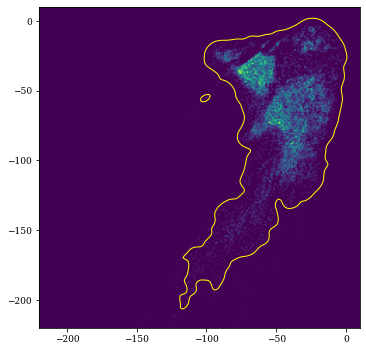

In [38]:
h_m,kde_m,k_m,l_m = calc_kde(seals_m,sigma=3,level=0.99)
fig,ax = plt.subplots(figsize=(5.9,5.9))
extent=[xmin,xmax,ymax,ymin]
plt.imshow(h_m,extent=extent)
contour = plt.contour(k_m, levels=[l_m], colors="yellow", linewidths=1,extent=[xmin,xmax,ymin,ymax])
plt.xlim(-220,xmax)
plt.ylim(-220,ymax)

#This yellow bounary encloses 99 percent of the seals

In [39]:
# Extract polygons from contour
polygons = [path.vertices for collection in contour.collections for path in collection.get_paths()]
polygon_shapes = [Polygon(coords) for coords in polygons]
colony_area = unary_union(polygon_shapes)

In [40]:
manual = manual[manual.progress_apply(lambda row: colony_area.contains(Point(row["position_x_meter"], row["position_y_meter"])), axis=1)]
print(f"Remaining entries in manual: {len(manual)}/{length_manual} ({len(manual)/length_manual:.1%})")

100%|██████████| 19121/19121 [00:01<00:00, 13539.55it/s]


Remaining entries in manual: 18920/22601 (83.7%)


In [41]:
fwb = fwb[fwb.progress_apply(lambda row: colony_area.contains(Point(row["position_x_meter"], row["position_y_meter"])), axis=1)]
print(f"Remaining entries in fwb: {len(fwb)}/{length_fwb} ({len(fwb)/length_fwb:.1%})")

100%|██████████| 4140130/4140130 [05:13<00:00, 13211.85it/s]


Remaining entries in fwb: 4068695/5122042 (79.4%)


## Filter: Excluding jetty, path, structures

In [42]:
# Also removes detections from the jetty/path/crate area used by sheathbills for resting,
# which is not considered part of the breeding colony.

In [55]:
exclude = Polygon([(-49.46681175190424, -14.054758800521512), (-53.057671381936885, -19.335071707953063), (-56.452665941240475, -21.095176010430247), (-58.0195865070729, -22.39895697522816), (-60.23939064200217, -23.833116036505867), (-61.545157780195865, -23.96349413298566), (-64.28726877040262, -22.985658409387224), (-65.85418933623504, -23.116036505867015), (-67.48639825897715, -23.76792698826597), (-71.27312295973884, -26.3102998696219), (-73.23177366702937, -27.744458930899608), (-75.05984766050054, -29.308996088657103), (-76.4961915125136, -30.74315514993481), (-79.63003264417846, -32.24250325945241), (-81.00108813928182, -31.590612777053455), (-79.56474428726877, -29.178617992177315), (-77.86724700761698, -27.222946544980445), (-75.58215451577802, -25.528031290743154), (-73.81936887921654, -23.89830508474576), (-70.94668117519042, -22.138200782268576), (-68.13928182807399, -20.63885267275098), (-66.18063112078346, -19.465449804432854), (-63.24265505984766, -17.444589308996086), (-61.08813928182807, -17.444589308996086), (-59.39064200217628, -15.749674054758799), (-56.90968443960826, -12.490221642764016), (-53.841131664853094, -10.40417209908735), (-51.621327529923825, -8.318122555410689), (-46.72470076169749, -5.775749674054758), (-44.50489662676822, -6.166883963494129), (-42.67682263329706, -7.079530638852674), (-41.95865070729053, -9.426336375488916), (-43.06855277475516, -11.251629726205998), (-44.70076169749728, -13.076923076923077), (-47.05114254624591, -14.250325945241197)])

In [44]:
manual = manual[
    ~((manual["class"].isin(["sheathbill", "skua", "giant petrel"])) & 
      (manual.progress_apply(lambda row: exclude.contains(Point(row["position_x_meter"], row["position_y_meter"])), axis=1)))
]
print(f"Remaining entries in manual: {len(manual)}/{length_manual} ({len(manual)/length_manual:.1%})")

100%|██████████| 18920/18920 [00:00<00:00, 27751.54it/s]

Remaining entries in manual: 18659/22601 (82.6%)


In [45]:
fwb = fwb[
    ~((fwb["class"].isin(["sheathbill", "skua", "giant petrel"])) & 
      (fwb.progress_apply(lambda row: exclude.contains(Point(row["position_x_meter"], row["position_y_meter"])), axis=1)))
]
print(f"Remaining entries in fwb: {len(fwb)}/{length_fwb} ({len(fwb)/length_fwb:.1%})")

100%|██████████| 4068695/4068695 [02:33<00:00, 26569.11it/s]


Remaining entries in fwb: 4000032/5122042 (78.1%)


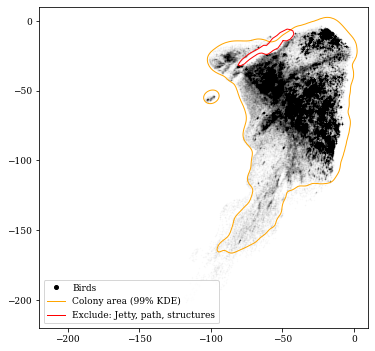

In [74]:
# Calculate the KDE and contour information.
h_m, kde_m, k_m, l_m = calc_kde(
    fwb[fwb["class"].isin(["sheathbill", "skua", "giant petrel"])],
    sigma=3,
    level=0.99
)

fig, ax = plt.subplots(figsize=(5.9, 5.9))
extent = [xmin, xmax, ymax, ymin]

# Plot bird positions (black points)
bird_data = fwb[fwb["class"].isin(["sheathbill", "skua", "giant petrel"])]
ax.scatter(*bird_data[["position_x_meter", "position_y_meter"]].values.T,
           color="black", s=1, alpha=0.01)

# Plot the KDE contour (orange line)
contour = ax.contour(k_m, levels=[l_m], colors="orange", linewidths=1,
                     extent=[xmin, xmax, ymin, ymax])

# Plot the exclusion polygon (red line)
x_ex, y_ex = exclude.exterior.xy
ax.plot(x_ex, y_ex, color="red", linewidth=1)

plt.xlim(-220, xmax)
plt.ylim(-220, ymax)

# Create custom legend handles.
bird_handle = mlines.Line2D([], [], marker='o', linestyle='None',
                            color='black', markersize=4, label='Birds')
contour_handle = mlines.Line2D([], [], color='orange', linewidth=1,
                               label='Colony area (99% KDE)')
exclude_handle = mlines.Line2D([], [], color='red', linewidth=1,
                               label='Exclude: Jetty, path, structures')

# Add the legend with custom handles.
ax.legend(handles=[bird_handle, contour_handle, exclude_handle], loc="lower left")

plt.show()

In [72]:
save_df_to_pickle(manual, "manual_filtered.pkl")
save_df_to_pickle(fwb, "fwb_filtered.pkl")

'tmp/fwb_filtered.pkl'

## Load filtered dataset

In [82]:
manual = load_df_from_pickle('manual_filtered.pkl')
fwb = load_df_from_pickle('fwb_filtered.pkl')

# Abundance

In [75]:
abundance_fwb = (
    fwb.groupby([fwb["timestamp"].dt.date, "timestamp", "class"])
       .size()
       .unstack(fill_value=0)
       .groupby(level=0)
       .max()
)

abundance_manual = (
    manual.groupby([manual["timestamp"].dt.date, "timestamp", "class"])
          .size()
          .unstack(fill_value=0)
          .groupby(level=0)
          .max()
)

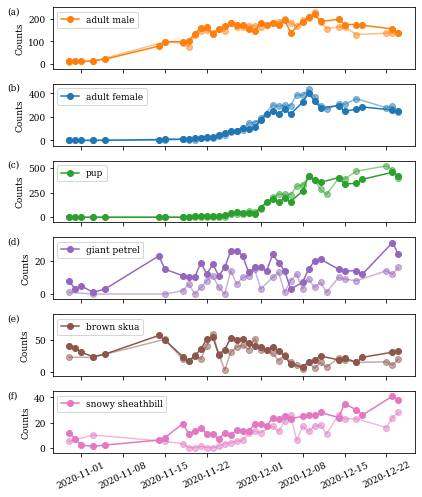

In [76]:
fontsize = 9
fig, axs = plt.subplots(figsize=(5.9, 7), nrows=6)
ax0, ax1, ax2, ax3, ax4, ax5 = axs
plt.subplots_adjust(hspace=0.15)

for i, animal in enumerate(["male", "female", "pup", "giant petrel", "skua", "sheathbill"]):
    ax = [ax0, ax1, ax2, ax3, ax4, ax5][i]
    ax.plot(abundance_fwb.index.values, abundance_fwb[animal].values, color=colors[animal], marker='o', label=labels[animal])
    ax.plot(abundance_manual.index.values, abundance_manual[animal].values, color=colors[animal], marker='o', alpha=0.5)

    max_val = np.max(np.concatenate((abundance_fwb[animal].values, abundance_manual[animal].values)))
    ax.set_ylim(-0.1 * max_val, max_val + 0.1 * max_val)

    ax.set_ylabel("Counts", fontsize=fontsize)
    ax.legend(loc='upper left', fontsize=fontsize)

    if animal == "skua":
        ax.set_ylim(-0.1 * max_val, 90)

    if i < len(axs) - 1:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        ax.tick_params(axis='x', rotation=25, labelsize=fontsize)

    ax.tick_params(axis='y', labelsize=fontsize)

abc = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
for label, ax in zip(abc, axs):
    ax.text(
        -0.07, 0.75, label,
        transform=ax.transAxes + ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans),
        fontsize='medium', va='bottom',
    )

plt.tight_layout()
plt.show()


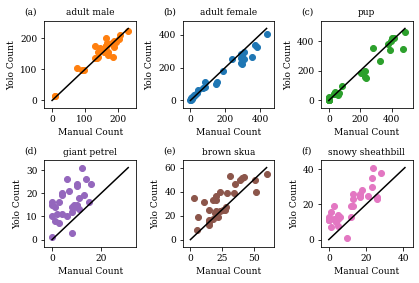

In [77]:
fontsize = 9
classes_to_plot = ["male", "female", "pup", "giant petrel", "skua", "sheathbill"]

abundance_fwb.index = pd.to_datetime(abundance_fwb.index)
abundance_manual.index = pd.to_datetime(abundance_manual.index)

common_dates = abundance_fwb.index.intersection(abundance_manual.index)

abundance_fwb_filtered = abundance_fwb.loc[common_dates]
abundance_manual_filtered = abundance_manual.loc[common_dates]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(5.9, 4))
axs = axs.flatten()

for i, cls in enumerate(classes_to_plot):
    ax = axs[i]
    
    if cls in abundance_fwb_filtered.columns and cls in abundance_manual_filtered.columns:
        x = abundance_manual_filtered[cls].values
        y = abundance_fwb_filtered[cls].values
        maxxy = np.max([np.max(x), np.max(y)])

        ax.scatter(x, y, color=colors[cls])

        ax.set_xlabel("Manual Count", fontsize=fontsize)
        ax.set_ylabel("Yolo Count", fontsize=fontsize)
        ax.set_title(labels[cls], fontsize=fontsize)
        ax.plot([0, maxxy], [0, maxxy], color="black")
        ax.set_xlim(-0.1 * maxxy, 1.1 * maxxy)
        ax.set_ylim(-0.1 * maxxy, 1.1 * maxxy)

for label, ax in zip([f"({chr(97 + i)})" for i in range(len(axs))], axs):
    ax.text(
        0.0, 0.98, label,
        transform=ax.transAxes + ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans),
        fontsize='medium', va='bottom',
    )

plt.tight_layout()
plt.show()


## Temporal patterns of abundance

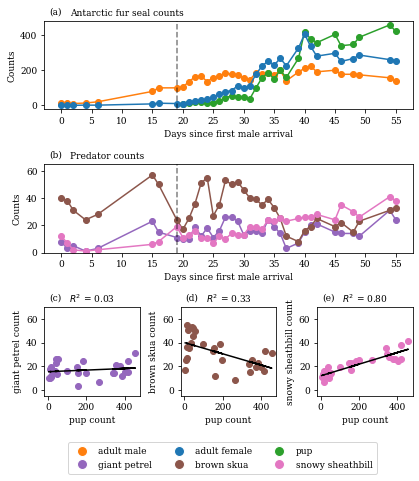

In [78]:
fontsize = 9
fig = plt.figure(figsize=(5.9, 6.1))
gs = GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 1])

xdays = [d.days for d in (abundance_fwb.index - abundance_fwb.index[0])]

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :], sharex=ax0)

for animal in ["male", "pup", "female"]:
    if animal == "pup":
        ax0.plot(np.array(xdays)[abundance_fwb[animal].values > 0], abundance_fwb[animal].values[abundance_fwb[animal].values > 0], color=colors[animal], label=animal, marker='o')
    else:
        ax0.plot(np.array(xdays), abundance_fwb[animal].values, color=colors[animal], label=animal, marker='o')

for animal in ["giant petrel", "skua", "sheathbill"]:
    ax1.plot(xdays, abundance_fwb[animal].values, color=colors[animal], label=labels[animal], marker='o')

first_born_pup = manual[manual["class"] == 'pup'].head(1)["timestamp"].dt.date.values[0]
ax0.axvline((first_born_pup - abundance_fwb.index[0].date()).days, color="black", linestyle="dashed", label="first-born pup", alpha=0.5)
ax1.axvline((first_born_pup - abundance_fwb.index[0].date()).days, color="black", linestyle="dashed", label="first-born pup", alpha=0.5)

plt.setp(ax0.get_xticklabels(), visible=True)
plt.setp(ax1.get_xticklabels(), visible=True)

ax0.set_ylabel("Counts", fontsize=fontsize)
ax1.set_ylabel("Counts", fontsize=fontsize)
ax1.set_ylim(0, 65)

ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[2, 1], sharey=ax2)
ax4 = fig.add_subplot(gs[2, 2], sharey=ax2)

mask = abundance_fwb.index.date > first_born_pup
species_list = ["giant petrel", "skua", "sheathbill"]
axs = [ax2, ax3, ax4]

for i, species in enumerate(species_list):
    ax = axs[i]
    x = abundance_fwb[mask].pup.values
    y = abundance_fwb[mask][species].values
    ax.scatter(x, y, color=colors[species])
    ax.set_xlabel("pup count", fontsize=fontsize)
    ax.set_ylabel(f"{labels[species]} count", fontsize=fontsize)
    ax.set_ylim(-5, 70)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line = slope * x + intercept
    ax.plot(x, line, color="black", label=f'Fit: R$^2$ = {r_value**2:.2f}')
    ax.text(0.5, 1.1, rf'$\mathit{{R}}^2$ = {r_value**2:.2f}', transform=ax.transAxes, ha='center', va='center', color='black', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

ax0.set_xlabel("Days since first male arrival")
ax1.set_xlabel("Days since first male arrival")
tick_positions = np.arange(0, max(xdays) + 1, 5)
ax0.set_xticks(tick_positions)
ax1.set_xticks(tick_positions)

ax0.text(0.07, 1.09, 'Antarctic fur seal counts', transform=ax0.transAxes, ha='left', va='center', color='black', fontsize=fontsize)
ax1.text(0.07, 1.09, 'Predator counts', transform=ax1.transAxes, ha='left', va='center', color='black', fontsize=fontsize)

for text_abc, ax in zip(["(a)", "(b)", "(c)", "(d)", "(e)"], [ax0, ax1, ax2, ax3, ax4]):
    ax.annotate(
        text_abc,
        xy=(0, 1.21), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top',
        bbox=dict(boxstyle="circle", facecolor='white', edgecolor='none', pad=0.2),
        zorder=2
    )

animals = ["male", "giant petrel", "female", "skua", "pup", "sheathbill"]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[a], markersize=10, label=labels[a]) for a in animals]
fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=3,
    borderpad=0.5,
    bbox_to_anchor=(0.53, -0.1)
)

plt.tight_layout()
plt.show()

## Spatial patterns of abundance

In [83]:
from cameratransform import load_camera

cam = load_camera(f"{folder}/camera.pkl")

invalid value encountered in divide


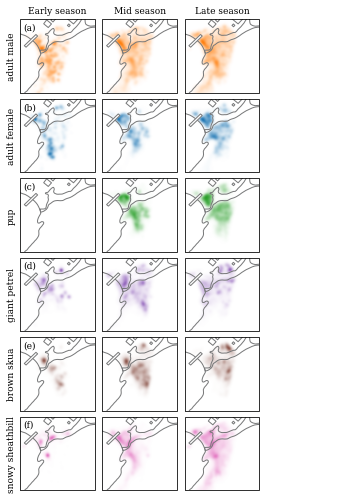

In [100]:
# === File paths ===
google_earth_fwb_area = f"{folder}/google_earth_map_area1_modified.tif"
fwb_contour = f"{folder}/google_earth_map_data.cdb"

# === KDE function ===
def calc_kde_gps(df, cam, animals, view_ext_space, sigma=1, level=0.95):
    """
    Compute a 2D kernel density estimate for GPS positions transformed into camera space.
    """
    df = df[df["class"].isin(animals)].copy()
    df["elevation"] = 0  # assume ground-level if missing
    xy = cam.spaceFromGPS(df[["latitude", "longitude", "elevation"]].values)[:,:2]
    (xmin, ymin, _), (xmax, ymax, _) = view_ext_space
    h = np.histogram2d(xy[:,0], xy[:,1],
                       bins=(np.arange(xmin, xmax, 1),
                             np.arange(ymin, ymax, 1)))[0].T
    kde = gaussian_filter(h, sigma=sigma)
    k = kde / kde.sum()
    f_sorted = np.sort(k.ravel())
    cumulative_f = np.cumsum(f_sorted) / f_sorted.sum()
    level_ = f_sorted[np.argmax(cumulative_f >= 1 - level)]
    return h, kde, k, level_

# === Polygon helper functions ===
def points_to_polygon(points):
    return Polygon(points)

def create_polygons(df):
    polygons = []
    for _, group in df.groupby("id"):
        polygons.append(points_to_polygon(group[["lon", "lat"]].values))
    return polygons

def plot_polygons(ax, polygons, color='black', facecolor='none', alpha=1):
    ax.add_geometries(
        polygons,
        crs=ccrs.PlateCarree(),
        edgecolor=color,
        facecolor=facecolor,
        alpha=alpha
    )

# === GeoTIFF utilities ===
def get_corner_coordinates(geotiff_path):
    with rasterio.open(geotiff_path) as dataset:
        bounds = dataset.bounds
    return bounds.left, bounds.right, bounds.bottom, bounds.top

def px2gps(x, y, gearth_ext, w, h):
    dlon = gearth_ext[1] - gearth_ext[0]
    dlat = gearth_ext[2] - gearth_ext[3]
    gps_lon = x / w * dlon + gearth_ext[0]
    gps_lat = y / h * dlat + gearth_ext[3]
    return gps_lon, gps_lat

# === Load baseline polygons from fwb_contour ===
gearth_ext = get_corner_coordinates(google_earth_fwb_area)
with clickpoints.DataFile(fwb_contour) as cdb:
    img = cdb.getImage(4).data
    h_img, w_img = img.shape[:2]

    def get_points_by_type(t):
        polys = cdb.getPolygons(type=t)
        if not polys:
            return pd.DataFrame(columns=["x_px", "y_px", "id", "lon", "lat"])
        rows = []
        for i, poly in enumerate(polys):
            points = poly.points
            tmp = np.hstack([points, np.full((len(points), 1), i)])
            rows.append(tmp)
        arr = np.vstack(rows)
        df = pd.DataFrame(arr, columns=["x_px", "y_px", "id"])
        df["x_px"] = df["x_px"].astype(float)
        df["y_px"] = df["y_px"].astype(float)
        df["id"] = df["id"].astype(int)
        df[["lon", "lat"]] = df.apply(
            lambda d: pd.Series(px2gps(d["x_px"], d["y_px"], gearth_ext, w_img, h_img)),
            axis=1
        )
        return df

    coastline  = get_points_by_type("coastline")
    building   = get_points_by_type("building")
    jetty      = get_points_by_type("jetty")
    stream     = get_points_by_type("stream")

coastline_polygons = create_polygons(coastline)
building_polygons  = create_polygons(building)
jetty_polygons     = create_polygons(jetty)
stream_polygons    = create_polygons(stream)

# === Define bounding box, time windows, and plotting parameters ===
# view_ext: (lon_left, lon_right, lat_bottom, lat_top)
view_ext = (-38.05380366554259, -38.05036560249325, -54.00988918444724, -54.00799516795809)
view_ext2 = (view_ext[0], view_ext[1], view_ext[3], view_ext[2])  # for set_extent

# Assume `cam` is a defined CameraTransform object with a method spaceFromGPS.
# Convert view_ext to camera space using two GPS corners:
view_ext_space = cam.spaceFromGPS(np.array([
    [view_ext[2], view_ext[0], 0],
    [view_ext[3], view_ext[1], 0]
]))

animals_list = ["male", "female", "pup", "giant petrel", "skua", "sheathbill"]
sigma = 3
level_value = 0.9
time_windows = [
    ("Early", [pd.Timestamp('2020-10-01'), pd.Timestamp('2020-11-17')]),
    ("Mid",   [pd.Timestamp('2020-10-18'), pd.Timestamp('2020-12-06')]),
    ("Late",  [pd.Timestamp('2020-12-07'), pd.Timestamp('2021-01-31')])
]

def timefilter(df, t):
    return df[(df["timestamp"] >= t[0]) & (df["timestamp"] <= t[1])]

fontsize = 9

# === Plotting ===
# Create a grid of subplots: 6 rows (animals) x 4 columns (3 time windows + annotation column)
nrows, ncols = len(animals_list), 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5.9, 22/2.54),
                        subplot_kw={'projection': ccrs.Mercator()})

# Set map extent and add baseline polygons to each subplot (skip the annotation column)
for i, ax in enumerate(axs.flatten()):
    if i % 4 == 3:
        ax.set_frame_on(False)
        continue
    ax.set_extent(view_ext2, ccrs.PlateCarree())
    plot_polygons(ax, coastline_polygons, color='#78797a')
    plot_polygons(ax, building_polygons, color='#78797a')
    plot_polygons(ax, jetty_polygons, color='#78797a', facecolor='#FFFFFF')
    plot_polygons(ax, stream_polygons, color='#78797a')

# Loop over time windows and animals to compute and display the KDE maps
for col_idx, (tw_label, tw) in enumerate(time_windows):
    for row_idx, animal in enumerate(animals_list):
        ax = axs[row_idx, col_idx]
        fwb_subset = timefilter(fwb, tw)  # fwb: DataFrame with 'timestamp' and 'class'
        _, kde, _, _ = calc_kde_gps(fwb_subset, cam, [animal], view_ext_space,
                                    sigma=sigma, level=level_value)
        ax.imshow(kde, extent=view_ext2, transform=ccrs.PlateCarree(), cmap=cmaps[animal])
        # Adjust axes limits if desired
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0] + 20, ylim[1] - 80)
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0] + 120, xlim[1])
        if col_idx == 0:
            ax.text(-0.05, 0.5, labels[animal], transform=ax.transAxes,
                    rotation=90, va='center', ha='right', fontsize=fontsize)

# Set titles for time window columns
axs[0, 0].set_title("Early season", fontsize=fontsize)
axs[0, 1].set_title("Mid season", fontsize=fontsize)
axs[0, 2].set_title("Late season", fontsize=fontsize)

# Add annotation labels to the first (leftmost) column
annotations = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)"]
for ax, ann in zip(axs[:, 0], annotations):
    ax.annotate(ann, xy=(0.04, 0.96), xycoords='axes fraction',
                xytext=(0.5, -0.5), textcoords='offset points',
                fontsize=fontsize, verticalalignment='top',
                bbox=dict(boxstyle="circle", facecolor='None', edgecolor='none', pad=0.1))

fig.subplots_adjust(wspace=0.0, hspace=0.08)
plt.show()


## Fine-scale pup acssociation behaviour

In [109]:
filename = f"pup_association_observed.pkl"
if os.path.exists(f"{folder}/{filename}"):
    nearest_df = load_df_from_pickle(filename)
else:
    # === Nearest Neighbor Calculation Using Actual Pups (Method 1) ===
    nearest_records = []
    
    for ts, group in tqdm(fwb.groupby("timestamp"), desc="Calculating Actual Nearest Neighbors"):
        pups = group[group["class"] == "pup"]
        if pups.empty:
            continue
    
        # Only process timestamps after a cutoff date
        if pd.to_datetime(ts) < pd.Timestamp("2020-11-18"):
            continue
    
        # Compute pairwise distances between each pup and all individuals in the same group
        distances = pairwise_distances(
            pups[["position_x_meter", "position_y_meter"]].values,
            group[["position_x_meter", "position_y_meter"]].values
        )
        # Exclude self-distance by replacing near-zero distances
        distances = np.where(distances < 1e-3, 1e6, distances)
    
        # For each pup, get its nearest neighbor in the group
        for i, (neighbor_idx, dist) in enumerate(zip(np.argmin(distances, axis=1), np.min(distances, axis=1))):
            pup_info = pups.iloc[i].to_dict()
            neighbor_info = group.iloc[neighbor_idx].to_dict()
            record = {
                **pup_info,
                "distance_pup_neighbor": dist,
                "neighbor_x": neighbor_info["position_x_meter"],
                "neighbor_y": neighbor_info["position_y_meter"],
                "neighbor_class": neighbor_info["class"]
            }
            nearest_records.append(record)
    
    nearest_df = pd.DataFrame(nearest_records)
    
    save_df_to_pickle(nearest_df, filename)

In [110]:
filename = "pup_association_random.pkl"
if os.path.exists(f"{folder}/{filename}"):
    random_neighbors_df = load_df_from_pickle(filename)
else:
    
    # Get unique timestamps
    unique_timestamps = fwb["timestamp"].unique()
    pup_data = fwb[fwb["class"] == "pup"]
    
    def get_random_pups(pup_data, current_group, current_ts, N=10):
        """
        Sample one random pup from each of N random timestamps (excluding the current timestamp).
        Repeat the drawing process until exactly N pups are selected.
        """
        while True:
            selected_random_pups = []
            
            # Get N random timestamps different from the current timestamp
            other_timestamps = unique_timestamps[unique_timestamps != current_ts]
            chosen_timestamps = np.random.choice(other_timestamps, N, replace=True)
            
            # Filter pup_data to only include timestamps in the chosen list
            pup_subset = pup_data[pup_data["timestamp"].isin(chosen_timestamps)]
            
            # For each chosen timestamp, select one random pup
            for ts in chosen_timestamps:
                pups_at_ts = pup_subset[pup_subset["timestamp"] == ts]
                if pups_at_ts.empty:
                    continue  # Skip if no pups found
                random_pup = pups_at_ts.sample(n=1)
                selected_random_pups.append(random_pup)
            
            # Check if we have exactly N pups; if not, try again
            if len(selected_random_pups) == N:
                return pd.concat(selected_random_pups, ignore_index=True)
    
    # Initialize output list for random neighbor results
    random_neighbors = []
    
    # Iterate over grouped timestamps
    for current_ts, current_group in tqdm(fwb.groupby("timestamp")):
        group_pups = current_group[current_group["class"] == "pup"]
        if len(group_pups) == 0:
            continue
    
        # Process only timestamps on/after 2020-11-18
        if pd.to_datetime(current_ts) < pd.Timestamp("2020-11-18"):
            continue
    
        # Get random pups from other timestamps (number equals the count of pups in current group)
        random_pup_samples = get_random_pups(pup_data, current_group, current_ts, N=len(group_pups))
        if random_pup_samples.empty:
            continue
    
        # Compute pairwise distances between random pup samples and all individuals in the current group
        dist_matrix = pairwise_distances(
            random_pup_samples[["position_x_meter", "position_y_meter"]].values, 
            current_group[["position_x_meter", "position_y_meter"]].values
        )
        
        # Exclude self by replacing near-zero distances with a large value
        dist_matrix = np.where(dist_matrix < 1e-3, 1e6, dist_matrix)
        
        # For each random pup sample, find the nearest neighbor in the current group
        for j, (min_index, min_distance) in enumerate(zip(np.argmin(dist_matrix, axis=1), np.min(dist_matrix, axis=1))):
            pup_info = random_pup_samples.iloc[j].to_dict()
            neighbor_info = current_group.iloc[min_index].to_dict()
            combined_info = {**pup_info, **{
                "distance_pup_neighbour": min_distance,
                "neighbour_x": neighbor_info["position_x_meter"],
                "neighbour_y": neighbor_info["position_y_meter"],
                "neighbour_class": neighbor_info["class"],
            }}
            random_neighbors.append(combined_info)
    
    # Convert list of results to a DataFrame
    random_neighbors_df = pd.DataFrame(random_neighbors)
    save_df_to_pickle(random_neighbors_df, filename)

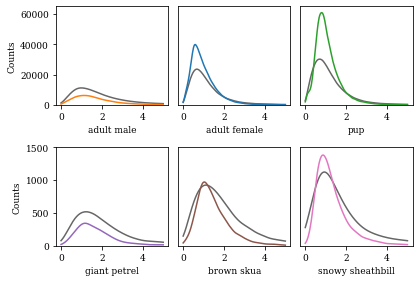

In [113]:
# Create a 2x3 grid of subplots
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(5.9, 4))
ax = ax.flatten()  # Flatten the array of axes

# Define histogram bins and compute bin width
bins = np.linspace(0, 5, 50)
bin_width = bins[1] - bins[0]

animals = ["male", "female", "pup", "giant petrel", "skua", "sheathbill"]

for i, animal in enumerate(animals):
    # Extract distance data from nearest_df and random_df
    data_vals = nearest_df[nearest_df.neighbor_class == animal]["distance_pup_neighbor"].values
    random_vals = random_neighbors_df[random_neighbors_df.neighbour_class == animal]["distance_pup_neighbour"].values

    # Create x-axis for KDE evaluation
    x_range = np.linspace(0, 5, 200)
    
    # Plot KDE for the random data (if sufficient points)
    if len(random_vals) > 1:
        kde_rand = gaussian_kde(random_vals)
        kde_rand_vals = kde_rand(x_range) * len(random_vals) * bin_width
        ax[i].plot(x_range, kde_rand_vals, color="black", alpha=0.6)
        
    # Plot KDE for the actual data (if sufficient points)
    if len(data_vals) > 1:
        kde_data = gaussian_kde(data_vals)
        kde_vals = kde_data(x_range) * len(data_vals) * bin_width
        ax[i].plot(x_range, kde_vals, color=colors[animal])
    
    # Set x-axis label using the label dictionary
    ax[i].set_xlabel(labels[animal], fontsize=fontsize)
    
    # Use different y-axis limits for top vs bottom row
    if i < 3:
        ax[i].set_ylim(0, 65000)
    else:
        ax[i].set_ylim(0, 1500)
    
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
    
    # Only add a y-label on the left-most subplots
    if i % 3 == 0:
        ax[i].set_ylabel("Counts", fontsize=fontsize)
    else:
        ax[i].set_yticks([])

plt.tight_layout()
plt.show()

## Fine-scale predator-prey dynamics

In [114]:
# --- Calculate predator-pup distances ---
def calc_predator_pup_distances(fwb, predator_list=["skua", "giant petrel", "sheathbill"], distance_threshold=10):
    records = []
    for ts, group in tqdm(fwb.groupby("timestamp"), desc="Calculating predator-pup distances"):
        pups = group[group["class"] == "pup"]
        if pups.empty:
            continue
        for pred in predator_list:
            pred_group = group[group["class"] == pred]
            if pred_group.empty:
                continue
            # Compute distances from each predator to every pup in the group
            dpp = pairwise_distances(
                pred_group[["position_x_meter", "position_y_meter"]].values,
                pups[["position_x_meter", "position_y_meter"]].values
            )
            for j, (min_idx, min_dist) in enumerate(zip(np.argmin(dpp, axis=1), np.min(dpp, axis=1))):
                if min_dist > distance_threshold:
                    continue
                # Get the coordinates of the closest pup for this predator
                pup_coords = pups.iloc[min_idx][["position_x_meter", "position_y_meter"]].values
                # Compute distances from this pup to all individuals in the group
                group_copy = group.copy()
                group_copy["distance"] = np.sqrt((group_copy["position_x_meter"] - pup_coords[0])**2 +
                                                 (group_copy["position_y_meter"] - pup_coords[1])**2)
                # Exclude the pup and the current predator from further search
                group_copy = group_copy[(group_copy["distance"] > 0.05) & (group_copy.index != pred_group.index[j])]
                if group_copy.empty:
                    continue
                # Find the nearest neighbour to the pup (excluding the pup itself and current predator)
                nearest_idx = group_copy["distance"].idxmin()
                nearest_row = group_copy.loc[nearest_idx]
                record = {
                    "ts": ts,
                    "predator": pred,
                    "predator_x": pred_group.iloc[j]["position_x_meter"],
                    "predator_y": pred_group.iloc[j]["position_y_meter"],
                    "distance_pred_pup": min_dist,
                    "pup_x": pup_coords[0],
                    "pup_y": pup_coords[1],
                    "distance_pup_neighbour": nearest_row["distance"],
                    "neighbour_x": nearest_row["position_x_meter"],
                    "neighbour_y": nearest_row["position_y_meter"],
                    "neighbour_class": nearest_row["class"]
                }
                records.append(record)
    return pd.DataFrame(records)

# --- Load or compute distances ---

filename =  "predator_pup_distances.pkl"
if os.path.exists(f"{folder}/{filename}"):
    distances = load_df_from_pickle(filename)
else:
    distances = calc_predator_pup_distances(fwb)
    save_df_to_pickle(distances, filename)

predator: giant petrel neighbour: male xhist peak: 1.3056839149489312 yhist peak: 3.2081886590176976
predator: giant petrel neighbour: female xhist peak: 0.6504425970015334 yhist peak: 3.7110994733396567
predator: giant petrel neighbour: pup xhist peak: 0.9648033813169049 yhist peak: 1.5278715424184925
predator: skua neighbour: male xhist peak: 0.8214481654530802 yhist peak: 4.553478115054147
predator: skua neighbour: female xhist peak: 0.6130404140502476 yhist peak: 2.9762202431670888
predator: skua neighbour: pup xhist peak: 0.9660960413025208 yhist peak: 1.3352426521666503
predator: sheathbill neighbour: male xhist peak: 1.3700230731241672 yhist peak: 1.8322386776963104
predator: sheathbill neighbour: female xhist peak: 0.6328669503795524 yhist peak: 1.532093795615415
predator: sheathbill neighbour: pup xhist peak: 0.8944206925167902 yhist peak: 1.0742282362982483


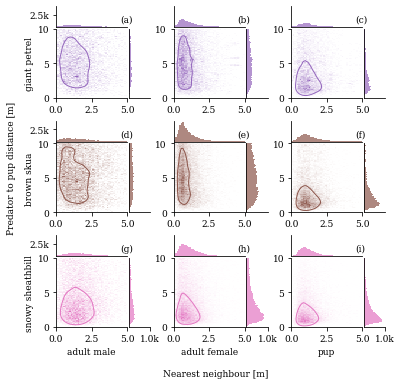

In [115]:


# --- KDE contour helper ---
def get_kde_contour_level(x, y, fraction=0.5, gridsize=100):
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    xx, yy = np.mgrid[x_min:x_max:gridsize*1j, y_min:y_max:gridsize*1j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    kernel = gaussian_kde(np.vstack([x, y]))
    density = np.reshape(kernel(positions), xx.shape)
    sorted_density = np.sort(density.ravel())[::-1]
    cumulative = np.cumsum(sorted_density)
    cumulative /= cumulative[-1]
    idx = np.searchsorted(cumulative, fraction)
    level = sorted_density[idx]
    return xx, yy, density, level

# --- Define plotting parameters ---
fontsize = 9


# Set row and column order:
# Rows: predator types; Columns: pup neighbour classes (from actual pup nearest neighbour search)
row_order = ["giant petrel", "skua", "sheathbill"]
col_order = ["male", "female", "pup"]

# --- Create a 3x3 grid with nested subplots ---
scale = 1
fig = plt.figure(figsize=(5.9 * scale, 5.9 * scale))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

outer = gridspec.GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

inner_hist2d_axes = []
inner_xhist_axes = []
inner_yhist_axes = []
xhist_ymax = []
yhist_xmax = []

# Loop over each cell in the 3x3 grid
for i in range(9):
    # Define nested gridspec for a given cell
    inner = gridspec.GridSpecFromSubplotSpec(
        2, 2,
        subplot_spec=outer[i],
        height_ratios=[0.3, 1],
        width_ratios=[1, 0.3],
        hspace=0.04,
        wspace=0.04
    )
    ax_hist2d = plt.subplot(inner[2])
    ax_xhist = plt.subplot(inner[0])
    ax_yhist = plt.subplot(inner[3])
    
    # Share axes for marginal histograms
    ax_xhist.sharex(ax_hist2d)
    ax_yhist.sharey(ax_hist2d)
    
    # Tidy up ticks and spines
    for ax in [ax_xhist, ax_yhist]:
        ax.tick_params(bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False, labelsize=fontsize)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    ax_hist2d.tick_params(axis="both", which="both", labelsize=fontsize)
    ax_hist2d.spines['top'].set_visible(False)
    ax_hist2d.spines['right'].set_visible(False)
    
    # Add labels on left and bottom edges
    if i % 3 == 0:
        ax_hist2d.set_ylabel(labels[row_order[i // 3]], fontsize=fontsize)
    if i // 3 == 2:
        ax_hist2d.set_xlabel(labels[col_order[i % 3]], fontsize=fontsize)
    
    # Extract data for this subplot: rows are predator; columns are neighbour class (from pup nearest neighbours)
    cell_data = distances[
        (distances.predator == row_order[i // 3]) & 
        (distances.neighbour_class == col_order[i % 3])
    ]
    x = cell_data["distance_pup_neighbour"].values  # distance from pup to its nearest neighbour
    y = cell_data["distance_pred_pup"].values         # distance from predator to pup
    
    # Define bins for histogram
    xbins = np.linspace(0, 5, 50)
    ybins = np.linspace(0, 10, 100)
    
    # 2D histogram
    ax_hist2d.hist2d(x, y, bins=[xbins, ybins], cmap=cmaps[row_order[i // 3]])
    
    # Compute and overlay KDE contour (50% contour level)
    if len(x) > 1 and len(y) > 1:
        xx, yy, density, level_50 = get_kde_contour_level(x, y, fraction=0.5)
        ax_hist2d.contour(xx, yy, density, levels=[level_50], colors=colors[row_order[i // 3]], linewidths=1)
    
    # Marginal histograms
    alpha = 0.7
    ax_xhist.hist(x, bins=xbins, color=colors[row_order[i // 3]], density=False, alpha=alpha)
    ax_yhist.hist(y, bins=ybins, color=colors[row_order[i // 3]], orientation='horizontal', density=False, alpha=alpha)
    
    # (Optional) Print peak positions for debugging
    xkde = stats.gaussian_kde(x) if len(x) > 1 else None
    ykde = stats.gaussian_kde(y) if len(y) > 1 else None
    if xkde is not None and ykde is not None:
        xx_vals = np.linspace(np.min(x), np.max(x), 1000)
        yy_vals = np.linspace(np.min(y), np.max(y), 1000)
        print('predator:', row_order[i // 3],
              'neighbour:', col_order[i % 3],
              'xhist peak:', xx_vals[np.argmax(xkde(xx_vals))],
              'yhist peak:', yy_vals[np.argmax(ykde(yy_vals))])
    
    # Collect maximum limits to normalize marginal plots later
    xhist_ymax.append(ax_xhist.get_ylim()[1])
    yhist_xmax.append(ax_yhist.get_xlim()[1])
    
    inner_hist2d_axes.append(ax_hist2d)
    inner_xhist_axes.append(ax_xhist)
    inner_yhist_axes.append(ax_yhist)

    if i in [0, 3, 6]:
        inner_xhist_axes[i].set_yticks([2500])
        inner_xhist_axes[i].set_yticklabels(["2.5k"])
        inner_xhist_axes[i].tick_params(left=True, labelleft=True, labelsize=fontsize)
    
    if i in [6, 7, 8]:
        inner_yhist_axes[i].set_xticks([1000])
        inner_yhist_axes[i].set_xticklabels(["1.0k"])
        inner_yhist_axes[i].tick_params(bottom=True, labelbottom=True, labelsize=fontsize)


# Normalize all marginal axes to the maximum limits across each row
xhist_ymax = np.max(np.array(xhist_ymax).reshape(3, 3), axis=1)
yhist_xmax = np.max(np.array(yhist_xmax).reshape(3, 3), axis=1)

for i in range(9):
    inner_xhist_axes[i].set_ylim(0, np.max(xhist_ymax))
    inner_yhist_axes[i].set_xlim(0, 1000)

# Annotate each subplot with a letter label
abc_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
for label_text, ax in zip(abc_labels, inner_xhist_axes):
    ax.annotate(
        label_text,
        xy=(0.9, 0.6),
        xycoords='axes fraction',
        fontsize=fontsize,
        verticalalignment='top',
        zorder=200,
        clip_on=False
    )

# Add overall x and y labels to the figure
fig.text(0.5, 0.01, 'Nearest neighbour [m]', ha='center', fontsize=fontsize)
fig.text(0.01, 0.5, 'Predator to pup distance [m]', va='center', rotation='vertical', fontsize=fontsize)

plt.show()